In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [ ]:
# Directory path where files are supposed to be uploaded
directory_path = '/content/drive/MyDrive/emotions_dataset'


In [ ]:
# Check if directory exists
if os.path.exists(directory_path) and os.path.isdir(directory_path):
    # List all files in the directory
    uploaded_files = os.listdir(directory_path)
    if uploaded_files:
        print(f"Files uploaded: {uploaded_files}")
    else:
        print("No files uploaded.")
else:
    print(f"Directory does not exist: {directory_path}")

Files uploaded: ['sad', 'happy', 'disgust', 'neutral', 'angry_modified', 'fear']


In [ ]:
data_directory='/content/drive/MyDrive/emotions_dataset'
# emotions = {
#     '01':'neutral',
#     '02':'calm',
#     '03':'happy',
#     '04':'sad',
#     '05':'angry',
#     '06':'fearful',
#     '07':'disgust',
#     '08':'surprised'
# }
emotions = {
        'sad': 0,
        'happy': 1,
        'disgust': 2,
        'neutral': 3,
        'angry_modified': 4,
        'fear': 5
    }

In [ ]:
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    """
    Extract features from audio files into numpy array.

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """
    result = np.array([])
    if chroma:
        stft = np.abs(librosa.stft(data))
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma_features))
    if mel:
        mel_features = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel_features))

    return result

In [ ]:
def noise(data, noise_factor):
    """
    Add random white noise to the audio.

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [ ]:
def shift(data, sampling_rate, shift_max, shift_direction):
    """
    Shift the spectrogram in a direction.

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [ ]:
# def load_data(save=False):
#     """
#     Loading dataset and applying augmentation.

#     Parameters
#     ----------
#     save : boolean, save the data to disk as .npy
#     """
#     x, y = [], []
#     for file in glob.glob(data_directory + "/Actor_*/*.wav"):
#         data, sr = librosa.load(file)  # Load the audio file
#         feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
#         x.append(feature)

#         file_name = os.path.basename(file)
#         # emotion = emotions[file_name.split("-")[2]]
#         y.append(emotions)

#         # Apply noise
#         n_data = noise(data, 0.001)
#         n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
#         x.append(n_feature)
#         y.append(emotions)

#         # Apply shift
#         s_data = shift(data, sr, 0.25, 'right')
#         s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
#         x.append(s_feature)
#         y.append(emotions)

#     if save:
#       np.save('X', np.array(x))
#       np.save('y', y)

#     return np.array(x), y

def load_data(save=False):
    """
    Loading dataset and applying augmentation.

    Parameters
    ----------
    save : boolean, save the data to disk as .npy
    """
    x, y = [], []
    for file in glob.glob(data_directory + "/*/*.wav"):
        try:
            # Load the audio file
            data, sr = librosa.load(file)
            feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
            x.append(feature)

            # Extract emotion from the folder name
            emotion = os.path.basename(os.path.dirname(file))
            if emotion in emotions:
                y.append(emotion)
            else:
                print(f"Skipping file {file} with unknown emotion: {emotion}")
                continue

            # Apply noise augmentation
            n_data = noise(data, 0.001)
            n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
            x.append(n_feature)
            y.append(emotion)

            # Apply shift augmentation
            s_data = shift(data, sr, 0.25, 'right')
            s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
            x.append(s_feature)
            y.append(emotion)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if save:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y


In [ ]:
x, y = load_data(save=False)
print(f"Features shape: {np.array(x).shape}, Labels length: {len(y)}")

Features shape: (783, 180), Labels length: 783


In [ ]:
import os

print(f"Data Directory Exists: {os.path.exists(data_directory)}")
print(f"Files in Directory: {os.listdir(data_directory)}")

Data Directory Exists: True
Files in Directory: ['sad', 'happy', 'disgust', 'neutral', 'angry_modified', 'fear']


In [ ]:
# Load data
X, y = load_data(save=True)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [ ]:
# Label encoding
labelencoder = LabelEncoder()
Y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# Get the number of features
print(f'Features extracted: {x_train.shape[1]}')
Y_train,y_train


Features extracted: 180


In [ ]:
# 4. Transformer-based Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, 256)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        transformer_out = self.transformer(embedded.permute(1, 0, 2))  # Sequence-first
        logits = self.classifier(transformer_out[0])  # Use the first token's output
        return logits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instantiate model
input_dim = 180  # Adjust if necessary
num_classes = 6  # Number of emotions
model = TransformerModel(input_dim=input_dim , num_classes=num_classes)
print(model)

TransformerModel(
  (embedding): Linear(in_features=180, out_features=256, bias=True)
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=20

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, X, y):  # Corrected constructor name
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):  # Corrected method name
        return len(self.X)

    def __getitem__(self, idx):  # Corrected method name
        return self.X[idx].unsqueeze(0), self.y[idx]  # Add channel dimension

In [ ]:
# # Create dataset instances
# train_dataset = AudioDataset(x_train, y_train)
# val_dataset = AudioDataset(x_test, y_test)

# # Create DataLoader instances
batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# import torch.nn.functional as F

# Initialize datasets and dataloaders
train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Training settings
epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerModel(
  (embedding): Linear(in_features=180, out_features=256, bias=True)
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=20

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item() * x_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss /= total
    train_accuracy = correct / total
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= total
    val_accuracy = correct / total
    # Log metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # Print metrics with epoch number
    print(f"Epoch [{epoch + 1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch [1/50] - Train Loss: 2.0926, Train Accuracy: 0.2125, Val Loss: 1.7018, Val Accuracy: 0.2038
Epoch [2/50] - Train Loss: 1.6364, Train Accuracy: 0.2588, Val Loss: 1.5924, Val Accuracy: 0.2484
Epoch [3/50] - Train Loss: 1.4791, Train Accuracy: 0.3450, Val Loss: 1.4821, Val Accuracy: 0.4140
Epoch [4/50] - Train Loss: 1.3740, Train Accuracy: 0.4058, Val Loss: 1.3791, Val Accuracy: 0.4968
Epoch [5/50] - Train Loss: 1.2799, Train Accuracy: 0.4569, Val Loss: 1.2723, Val Accuracy: 0.4459
Epoch [6/50] - Train Loss: 1.1938, Train Accuracy: 0.4856, Val Loss: 1.2033, Val Accuracy: 0.5732
Epoch [7/50] - Train Loss: 1.0418, Train Accuracy: 0.5495, Val Loss: 1.0778, Val Accuracy: 0.6306
Epoch [8/50] - Train Loss: 0.8846, Train Accuracy: 0.6438, Val Loss: 1.0613, Val Accuracy: 0.5987
Epoch [9/50] - Train Loss: 0.8032, Train Accuracy: 0.6821, Val Loss: 0.9460, Val Accuracy: 0.7070
Epoch [10/50] - Train Loss: 0.8049, Train Accuracy: 0.7173, Val Loss: 0.9220, Val Accuracy: 0.6815
Epoch [11/50] - Tra

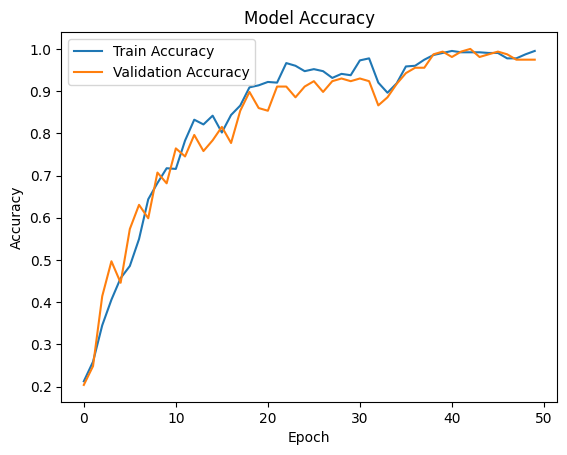

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a dictionary 'history' to store accuracy values
# For example:
# history = {'train_accuracy': [0.85, 0.87, ...], 'val_accuracy': [0.80, 0.83, ...]}

# Plotting the accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
import torch
import librosa

# Function to load and preprocess a single audio file for prediction
def predict_emotion(audio_file_path, model, labelencoder, device):
    # Load the audio file
    data, sr = librosa.load(audio_file_path)

    # Extract features using your existing extract_feature function
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)

    # Reshape feature to match the input format of the model (batch_size, channels, length)
    feature = feature.reshape(1, 1, -1)  # Add batch dimension and channel dimension

    # Convert feature to a PyTorch tensor
    feature_tensor = torch.tensor(feature, dtype=torch.float32).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform the forward pass and get the model's output
    with torch.no_grad():
        output = model(feature_tensor)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    # Map the predicted class to the actual emotion label
    predicted_emotion = labelencoder.inverse_transform([predicted_class.item()])
    return predicted_emotion[0]

In [ ]:
# Example usage:

# Replace 'your_audio_file.wav' with the path to your audio clip
audio_file_path ='/content/drive/MyDrive/emotions_dataset/happy/happy3.wav'

# Get device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model (make sure it's on the correct device)
model.to(device)

# Predict the emotion for the given audio file
predicted_emotion = predict_emotion(audio_file_path, model, labelencoder, device)

# Print the predicted emotion
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: happy


In [ ]:
import torch
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, test_loader, device):
    """
    Calculate the accuracy of the model on the test dataset.

    Args:
    - model: Trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: Device to perform computation ('cuda' or 'cpu')

    Returns:
    - accuracy: Accuracy of the model on the test dataset
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Get predicted classes
            _, preds = torch.max(outputs, 1)
             # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [ ]:
# Example Usage
# Assuming you have a trained model, test_loader, and device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_accuracy = calculate_accuracy(model, val_loader, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 97.45%


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, classes, device):
    """
    Generates and plots a confusion matrix for the model's predictions.

    Args:
    - model: Trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of emotion class names
    - device: Device to perform computation ('cuda' or 'cpu')

    Returns:
    - Confusion matrix plot
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            outputs = model(features)

            # Get predicted classes
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(classes)))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

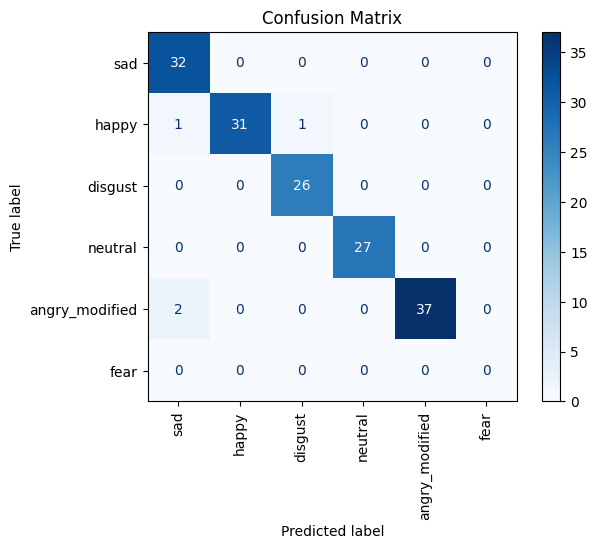

In [ ]:
# Example Usage
# Assuming you have a trained model, test_loader, and class names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# List of emotion labels (ensure it matches the order of classes in training)
classes = ['sad', 'happy', 'disgust', 'neutral', 'angry_modified', 'fear']

# Plot confusion matrix
plot_confusion_matrix(model, val_loader, classes,device)

In [ ]:
import torch

# Assuming model is your PyTorch model
torch.save(model.state_dict(), "transformer_model.pth")
print("Model saved successfully!")

Model saved successfully!
